In [1]:
# data manipulation 
import numpy as np
import pandas as pd

from datetime import datetime
import itertools

from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AR

from sklearn.model_selection import TimeSeriesSplit
from sklearn import metrics

import math

# data visualization 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from pylab import rcParams

%matplotlib inline

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

from proj_acquire import *
from proj_prepare import *

import zgulde.extend_pandas as ep
import seaborn as sns
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_cross_validation_metric, plot_forecast_component

In [2]:
df = prepare_fitbit()

In [3]:
# rename index to date
df.rename(columns={'index': 'date'}, inplace=True)

# set date to index
df.set_index('date', inplace=True)

# dropping columns with mostly zero information
to_drop = ['calories', 'carbs', 'fat', 'fiber',
       'protien', 'sodium', 'water']
df = df.drop(columns=(to_drop))

# remove commas and convert to float64
for col in df:
    df[col] = df[col].str.replace(',', '')
    df[col] = df[col].astype('float64')

# drop NaN rows as we'll be predicting them anyway
df.dropna(inplace=True)

In [ ]:
for col in df:
    print(f'{col} outliers:{df[col].outliers().sum()}')

In [ ]:
sns.pairplot(df)

In [ ]:
df.correlation_heatmap(fancy=True)

In [ ]:
def peekatdata(df):
    '''gives cursory sample of dataframe passed'''
    head_df = df.head(5)
    print(head_df)
    tail_df = df.tail(5)
    print(tail_df)
    shape_tuple = df.shape
    print(shape_tuple)
    describe_df = df.describe()
    print(describe_df)
    df.info()

In [ ]:
train = df['2018-04':'2018-09']
test = df['2018-10':'2018-12']
print(train.nunique())
print(test.nunique())

# Exploration

### mean total calories by day

In [ ]:
t_cal = train.resample('D').total_calories.mean()
t_cal.plot()
plt.title('mean total calories by day')
plt.ylabel('calories')
plt.xlabel('day')

### mean total calories by week

In [ ]:
t_cal.resample('W').mean().plot()
plt.title('mean total calories by week')
plt.ylabel('calories')
plt.xlabel('weeks')

### mean total calories by month

In [ ]:
t_cal.resample('M').mean().plot()
plt.title('mean total calories by month')
plt.ylabel('calories')
plt.xlabel('month')

### 5 period rolling mean and plot

In [ ]:
t_cal.head(10)

In [ ]:
t_cal.rolling(5).mean().plot(figsize=(12, 4))

### 10 period rolling mean and plot

In [ ]:
t_cal.rolling(10).mean().plot(figsize=(12, 4))

### Time-series decomposition - trend, seasonality, and noise

In [ ]:
decomposition = sm.tsa.seasonal_decompose(t_cal, model='additive')
fig = decomposition.plot()
plt.show()

### lag plot

In [ ]:
pd.plotting.lag_plot(t_cal)

### pearson's correlation coef

In [ ]:
df_corr = pd.concat([t_cal.shift(1), t_cal], axis=1)
df_corr.columns = ['t-1','t+1']
result = df_corr.corr()
print(result)

# Modeling

In [ ]:
agg1 = 'mean'
agg2 = 'sum'

In [ ]:
ts_data1 = df.total_calories.resample('W').agg(agg1)
ts_data2 = df.total_calories.resample('W').agg(agg2)

In [ ]:
train_size1 = int(len(ts_data1) * 0.66)
train_1, test_1 = ts_data1[0:train_size1], ts_data1[train_size1:len(ts_data1)]
print('Observations: %d' % (len(ts_data1)))
print('Training Observations: %d' % (len(train_1)))
print('Testing Observations: %d' % (len(test_1)))

train_size2 = int(len(ts_data2) * 0.66)
train_2, test_2 = ts_data2[0:train_size2], ts_data2[train_size2:len(ts_data2)]
print('Observations: %d ' % (len(ts_data2)))
print('Training Observations: %d' % (len(train_2)))
print('Testing Observations: %d' % (len(test_2)))

In [ ]:
plt.subplot(211)
plt.plot(train_1)
plt.plot(test_1)

plt.subplot(212)
plt.plot(train_1)
plt.plot(test_1)

plt.show()

### Simple Average

In [ ]:
train = df['2018-04':'2018-09'].total_calories.resample('D').agg('mean')
test = df['2018-10':'2018-12'].total_calories.resample('D').agg('mean')
print('Observations: %d' % (len(train.values) + len(test.values)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))

In [ ]:
yhat = pd.DataFrame(dict(actual=test))
yhat['avg_forecast'] = train.mean()
yhat['diff'] = yhat['actual'] - yhat['avg_forecast']
yhat.head()

In [ ]:
def plot_data_and_predictions(predictions, label):
    plt.figure(figsize=(10, 8))

    plt.plot(train,label='Train')
    plt.plot(test, label='Test')
    plt.plot(predictions, label=label, linewidth=5)

    plt.legend(loc='best')
    plt.show()


def evaluate(actual, predictions, output=True):
    mse = metrics.mean_squared_error(actual, predictions)
    rmse = math.sqrt(mse)

    if output:
        print('MSE:  {}'.format(mse))
        print('RMSE: {}'.format(rmse))
    else:
        return mse, rmse    

def plot_and_eval(predictions, actual=test, metric_fmt='{:.2f}', linewidth=4):
    if type(predictions) is not list:
        predictions = [predictions]

    plt.figure(figsize=(16, 8))
    plt.plot(train,label='Train')
    plt.plot(test, label='Test')

    for yhat in predictions:
        mse, rmse = evaluate(actual, yhat, output=False)        
        label = f'{yhat.name}'
        if len(predictions) > 1:
            label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
        plt.plot(yhat, label=label, linewidth=linewidth)

    if len(predictions) == 1:
        label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
        plt.title(label)

    plt.legend(loc='best')
    plt.show()    

In [ ]:
plot_and_eval(yhat.avg_forecast)

In [ ]:
periods = 30
yhat['moving_avg_forecast_30'] = train.rolling(30).mean().iloc[-1]

plot_and_eval(yhat.moving_avg_forecast_30)

In [ ]:
yhat.head()

In [ ]:
yhat['moving_avg_forecast_60'] = train.rolling(60).mean().iloc[-1]

plot_and_eval(yhat.moving_avg_forecast_60)

In [ ]:
import statsmodels.api as sm

sm.tsa.seasonal_decompose(train).plot()
result = sm.tsa.stattools.adfuller(train)
plt.show()

In [ ]:
# train = df['2018-04':'2018-09'].total_calories.resample('D').agg('mean')
# test = df['2018-10':'2018-12'].total_calories.resample('D').agg('mean')

sm.tsa.seasonal_decompose(train).plot()
result = sm.tsa.stattools.adfuller(train)
plt.show()

In [ ]:
from statsmodels.tsa.api import Holt

holt = Holt(train).fit(smoothing_level=.3, smoothing_slope=.05)

yhat['holt_linear'] = holt.forecast(test.shape[0])

plot_and_eval(yhat.holt_linear)

In [ ]:
using_last_quarter = train['2018-07':'2018-09']\
    .reset_index()\
    .drop(columns='date')\
    .set_index(train['2018-07':'2018-09'].index+90)
yhat['next_90'] = using_last_quarter
plot_and_eval(yhat.next_90, linewidth=1)

# Prophet

In [ ]:
df.columns

In [ ]:
import seaborn as sns
from fbprophet import Prophet

In [ ]:
df.reset_index(inplace=True)
df.head()

In [ ]:
d_df = pd.DataFrame()
d_df['y'] = df.distance
d_df['ds'] = pd.to_datetime(df['date'])

d_df = d_df.groupby(['ds'])['y'].sum().reset_index()

In [ ]:
plt.figure(figsize=(16,6))
sns.lineplot(d_df.ds, d_df.y)

In [ ]:
d_df.head()

In [ ]:
d_df['cap'] = 11
d_df['floor'] = 1

m = Prophet(daily_seasonality=True, growth='logistic',changepoint_range=0.9)
m.fit(d_df)

In [ ]:
future = m.make_future_dataframe(periods=92)
future['cap'] = 11
future['floor'] = 1
print(future.head())
print(future.tail())
print(d_df.tail())

In [ ]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

In [ ]:
fig1 = m.plot(forecast)

In [ ]:
fig2 = m.plot_components(forecast)

In [ ]:
from fbprophet.diagnostics import cross_validation, performance_metrics
# cross_validation(m, initial = 730, period = 180, horizon = 365, units = 'days')
df_cv = cross_validation(m, horizon='30 days')

In [ ]:
df_cv.head(40)

In [ ]:
df_p = performance_metrics(df_cv)
df_p.head(40)

In [ ]:
df_p.tail(40)

In [ ]:
df_p['hornum'] = df_p['horizon'].astype('str').str[:2].astype('int')

In [ ]:
sns.lineplot('hornum', 'rmse', data=df_p)

In [ ]:
from fbprophet.plot import plot_cross_validation_metric, plot_forecast_component

# plot_forecast_component(m, forecast, 'yhat')

fig3 = plot_cross_validation_metric(df_cv, metric='rmse')

In [ ]:
from datetime import timedelta, datetime
import itertools

In [ ]:
# df.reset_index('date', inplace=True)

In [ ]:
# - Write a function to parse a date column into 6 additional 
# columns (while keeping the original date): year, quarter, month, day of month, day of week, weekend vs. weekday
def add_date_parts(df):
    df = df.copy()
    df['year'] = df.date.dt.year
    df['quarter'] = df.date.dt.quarter
    df['month'] = df.date.dt.month
    df['day'] = df.date.dt.day
    df['hour'] = df.date.dt.hour
    df['dayofweek'] = df.date.dt.dayofweek
    df['weekday'] = df.date.dt.day_name().str[:3]
    # df['weekday'] = df.date.dt.day_name().str[:3]
    df['is_weekday'] = ((pd.DatetimeIndex(df.date).dayofweek) < 5)
    return df.set_index('date')


# - Create a new dataframe that aggregates the sales_total and 
# sale_amount(item count) using sum and median by day of week.
def aggregate_by_weekday(df):
    df = df.copy()
    by_dayofweek = pd.DataFrame()
    by_dayofweek['quantity_sum'] = df.groupby(['weekday']).quantity.sum()
    by_dayofweek['item_cnt_sum'] = df.groupby(['weekday']).sale_total.sum()
    by_dayofweek['quantity_median'] = df.groupby(['weekday']).quantity.median()
    by_dayofweek['item_cnt_median'] = df.groupby(['weekday']).sale_total.median()
    return by_dayofweek

In [ ]:
df = add_date_parts(df)

In [ ]:
df.head()

In [ ]:
df.info()

In [ ]:
df.head(20)

In [ ]:
ddf = df[df['dayofweek'].isin([4,5,6])]

ddf.reset_index(inplace=True)
ddf['y'] = ddf.distance
ddf['ds'] = pd.to_datetime(ddf.date)

plt.figure(figsize=(16,6))
sns.lineplot(d_df.ds, d_df.y)

In [ ]:
d_df['cap'] = 11
d_df['floor'] = 1

m = Prophet(daily_seasonality=False, growth='logistic', changepoint_range=0.9)
m.fit(d_df)

In [ ]:
future = m.make_future_dataframe(periods=22)
future['cap'] = 11
future['floor'] = 1
print(future.head())
print(future.tail())
print(d_df.tail())

In [ ]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

In [ ]:
fig1 = m.plot(forecast)

In [ ]:
fig2 = m.plot_components(forecast)

In [ ]:
df_cv = cross_validation(m, horizon='10 days')


df_p = performance_metrics(df_cv)
df_p.head(5)

In [ ]:
fig3 = plot_cross_validation_metric(df_cv, metric='rmse')

In [ ]:
ddf = df[df['dayofweek'].isin([0,1,2,3])]

ddf.reset_index(inplace=True)
ddf['y'] = ddf.distance
ddf['ds'] = pd.to_datetime(ddf.date)

plt.figure(figsize=(16,6))
sns.lineplot(d_df.ds, d_df.y)

In [ ]:
ddf['cap'] = 11
ddf['floor'] = 1

m = Prophet(daily_seasonality=False, growth='logistic', changepoint_range=0.9)
m.fit(ddf)

In [ ]:
future2 = m.make_future_dataframe(periods=22)
future2['cap'] = 11
future2['floor'] = 1
print(future2.head())
print(future2.tail())
print(ddf.tail())

In [ ]:
forecast2 = m.predict(future)
forecast2[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

In [ ]:
fig2 = m.plot(forecast2)

In [ ]:
fig2 = m.plot_components(forecast)

In [ ]:
ddf2 = df[df['dayofweek'].isin([4,5,6])]

ddf2.reset_index(inplace=True)
ddf2['y'] = ddf2.distance
ddf2['ds'] = pd.to_datetime(ddf2.date)

plt.figure(figsize=(16,6))
sns.lineplot(ddf2.ds, ddf2.y)

In [ ]:
ddf2.info()

In [ ]:
ddf.set_index('date', inplace=True)
ddf2.set_index('date', inplace=True)

In [ ]:
train = ddf['2018-07-15':'2018-10'].distance.resample('D').agg('mean')
test = ddf['2018-11':'2018-12'].distance.resample('D').agg('mean')

train2 = ddf2['2018-07-15':'2018-10'].distance.resample('D').agg('mean')
test2 = ddf2['2018-11':'2018-12'].distance.resample('D').agg('mean')

print('Observations: %d' % (len(train.values) + len(test.values)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(train)
plt.plot(test)
plt.plot(train2)
plt.plot(test2)
plt.legend()
plt.show()

In [ ]:
ts_data = df.distance.resample('D').agg('sum')

train_size = int(len(ts_data) * 0.85)
train_1, test_1 = ts_data[0:train_size], ts_data[train_size:len(ts_data)]
print('Observations: %d' % (len(ts_data)))
print('Training Observations: %d' % (len(train_1)))
print('Testing Observations: %d' % (len(test_1)))

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(train_1)
plt.plot(test_1)
plt.legend()
plt.show()

In [ ]:
sns.lineplot(df.weekday, df.steps)

In [ ]:
sns.lineplot(df.weekday, df.distance)

In [ ]:
sns.swarmplot(df.weekday, df.distance)

In [ ]:
sns.violinplot(df.weekday, df.distance)

In [ ]:
sns.boxplot(df.weekday, df.distance)

# Sandy's attempts at looping through the features...

In [39]:
df_p.drop(columns=['horizon_num'], inplace=True)

In [40]:
df_p.head()

,horizon,mse,rmse,mae,mape,coverage
92,3 days,854190.751553,924.224405,627.077257,0.343328,0.857143
63,4 days,859671.887044,927.184926,630.285099,0.349295,0.857143
153,4 days,860285.598516,927.515821,633.811466,0.350313,0.857143
33,4 days,738595.145768,859.415584,585.900680,0.319561,0.857143
183,4 days,735342.470461,857.521120,574.466679,0.316494,0.857143


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Results for the  activity_calories  feature:


INFO:fbprophet:Making 7 forecasts with cutoffs between 2018-08-08 00:00:00 and 2018-11-06 00:00:00
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Top of performance metrics for  activity_calories sorted by rmse:
    horizon            mse        rmse         mae      mape  coverage  \
49  20 days  952266.013211  975.841182  859.964891  2.372345  0.476190   
169 20 days  946705.337082  972.987840  856.606647  2.349765  0.523810   
17  18 days  936006.446986  967.474262  805.730720  5.098086  0.571429   

     median  diff_of_rmse_&_median  percent_diff  
49   1481.0             505.158818      0.341093  
169  1481.0             508.012160      0.343020  
17   1481.0             513.525738      0.346743  
median of percent diff for  activity_calories :  0.47146093275004286
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

Results for the  distance  feature:


INFO:fbprophet:Making 7 forecasts with cutoffs between 2018-08-08 00:00:00 and 2018-11-06 00:00:00
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Top of performance metrics for  distance sorted by rmse:
    horizon       mse      rmse       mae       mape  coverage  median  \
92   3 days  8.289575  2.879162  2.200756  13.803520  0.619048    3.68   
153  4 days  7.949251  2.819442  2.148786  13.837355  0.666667    3.68   
63   4 days  7.948827  2.819366  2.145611  13.836744  0.666667    3.68   

     diff_of_rmse_&_median  percent_diff  
92                0.800838      0.217619  
153               0.860558      0.233847  
63                0.860634      0.233868  
median of percent diff for  distance :  0.3589062085624734
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

Results for the  floors  feature:


INFO:fbprophet:Making 7 forecasts with cutoffs between 2018-08-08 00:00:00 and 2018-11-06 00:00:00
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Top of performance metrics for  floors sorted by rmse:
    horizon         mse       rmse        mae  mape  coverage  median  \
153  4 days  618.404741  24.867745  12.879156   inf  0.809524     7.0   
92   3 days  625.125666  25.002513  13.078614   inf  0.809524     7.0   
63   4 days  627.407004  25.048094  13.300565   inf  0.809524     7.0   

     diff_of_rmse_&_median  percent_diff  
153              17.867745      2.552535  
92               18.002513      2.571788  
63               18.048094      2.578299  
median of percent diff for  floors :  2.5717875991972394
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

Results for the  mins_active_high  feature:


INFO:fbprophet:Making 7 forecasts with cutoffs between 2018-08-08 00:00:00 and 2018-11-06 00:00:00
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Top of performance metrics for  mins_active_high sorted by rmse:
    horizon          mse       rmse        mae  mape  coverage  median  \
63   4 days  2096.626224  45.788931  39.734286   inf   0.47619    15.0   
153  4 days  2101.995053  45.847520  40.236534   inf   0.47619    15.0   
92   3 days  2137.851574  46.236907  40.150648   inf   0.47619    15.0   

     diff_of_rmse_&_median  percent_diff  
63               30.788931      2.052595  
153              30.847520      2.056501  
92               31.236907      2.082460  
median of percent diff for  mins_active_high :  2.0565013066535665
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

Results for the  mins_active_light  feature:


INFO:fbprophet:Making 7 forecasts with cutoffs between 2018-08-08 00:00:00 and 2018-11-06 00:00:00
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Top of performance metrics for  mins_active_light sorted by rmse:
    horizon           mse        rmse        mae      mape  coverage  median  \
137 18 days  12046.680511  109.757371  83.381190  3.068490  0.714286   203.0   
17  18 days  11996.790841  109.529863  82.720135  3.067737  0.714286   203.0   
138 19 days  11886.658846  109.025955  81.544624  3.063733  0.714286   203.0   

     diff_of_rmse_&_median  percent_diff  
137              93.242629      0.459323  
17               93.470137      0.460444  
138              93.974045      0.462926  
median of percent diff for  mins_active_light :  0.6757664804073794
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

Results for the  mins_active_med  feature:


INFO:fbprophet:Making 7 forecasts with cutoffs between 2018-08-08 00:00:00 and 2018-11-06 00:00:00
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Top of performance metrics for  mins_active_med sorted by rmse:
    horizon         mse       rmse        mae  mape  coverage  median  \
92   3 days  281.744197  16.785237  13.542407   inf  0.714286    11.0   
153  4 days  285.667298  16.901695  13.727689   inf  0.714286    11.0   
63   4 days  288.567716  16.987281  13.809361   inf  0.714286    11.0   

     diff_of_rmse_&_median  percent_diff  
92                5.785237      0.525931  
153               5.901695      0.536518  
63                5.987281      0.544298  
median of percent diff for  mins_active_med :  0.5365177395119702
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

Results for the  mins_sedentary  feature:


INFO:fbprophet:Making 7 forecasts with cutoffs between 2018-08-08 00:00:00 and 2018-11-06 00:00:00
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Top of performance metrics for  mins_sedentary sorted by rmse:
    horizon           mse        rmse         mae      mape  coverage  median  \
92   3 days  53569.521114  231.450904  168.763731  1.277278  0.904762   750.0   
63   4 days  51203.551193  226.282017  161.099270  1.271243  0.904762   750.0   
153  4 days  50679.467155  225.121006  159.228671  1.264682  0.904762   750.0   

     diff_of_rmse_&_median  percent_diff  
92              518.549096      0.691399  
63              523.717983      0.698291  
153             524.878994      0.699839  
median of percent diff for  mins_sedentary :  0.8238231870151846
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

Results for the  steps  feature:


INFO:fbprophet:Making 7 forecasts with cutoffs between 2018-08-08 00:00:00 and 2018-11-06 00:00:00
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Top of performance metrics for  steps sorted by rmse:
    horizon           mse         rmse          mae       mape  coverage  \
92   3 days  4.051571e+07  6365.195519  4928.057992  13.247295  0.571429   
153  4 days  3.903020e+07  6247.415592  4824.507927  13.282362  0.571429   
63   4 days  3.902764e+07  6247.210936  4815.247576  13.281554  0.571429   

     median  diff_of_rmse_&_median  percent_diff  
92   7806.0            1440.804481      0.184577  
153  7806.0            1558.584408      0.199665  
63   7806.0            1558.789064      0.199691  
median of percent diff for  steps :  0.33848712409567727
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

Results for the  total_calories  feature:


INFO:fbprophet:Making 7 forecasts with cutoffs between 2018-08-08 00:00:00 and 2018-11-06 00:00:00


Top of performance metrics for  total_calories sorted by rmse:
    horizon            mse        rmse         mae      mape  coverage  \
17  18 days  894413.677851  945.734465  720.193944  0.358760  0.619048   
137 18 days  874627.177441  935.215043  702.722951  0.355720  0.666667   
63   4 days  871966.091873  933.791246  644.554752  0.350502  0.619048   

     median  diff_of_rmse_&_median  percent_diff  
17   3385.0            2439.265535      0.720610  
137  3385.0            2449.784957      0.723718  
63   3385.0            2451.208754      0.724138  
median of percent diff for  total_calories :  0.8271041477414698
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

['activity_calories', 'distance', 'floors', 'mins_active_high', 'mins_active_light', 'mins_active_med', 'mins_sedentary', 'steps', 'total_calories']
[0.47146093275004286, 0.3589062085624734, 2.5717875991972394, 2.0565013066535665, 0.6757664804073794, 0.5365177395119702, 0.8238231870151846, 0.33848712409567727, 0.82710

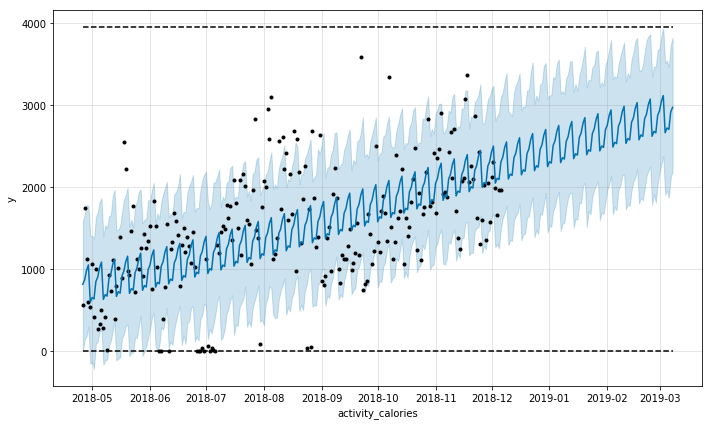

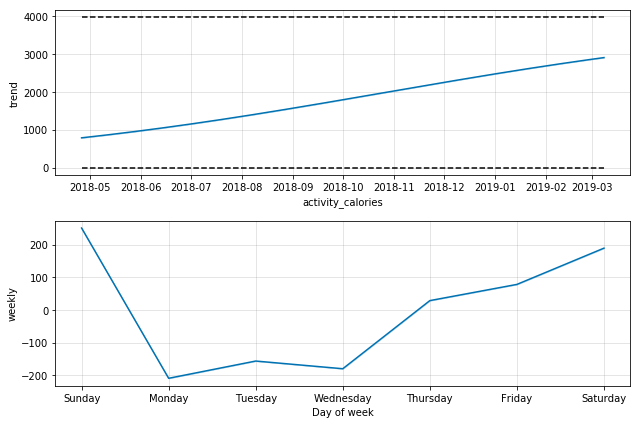

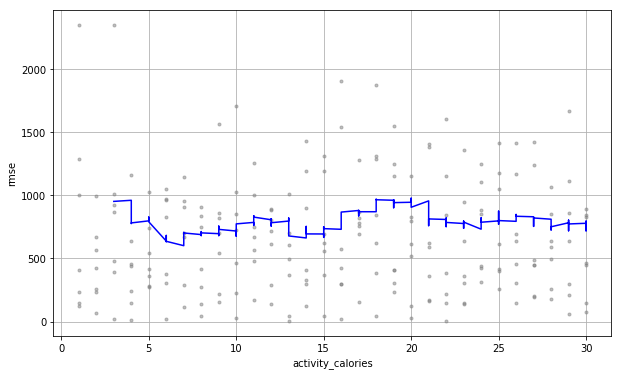

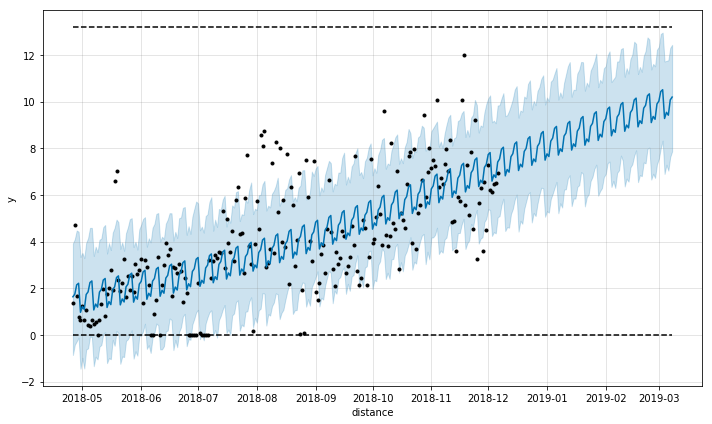

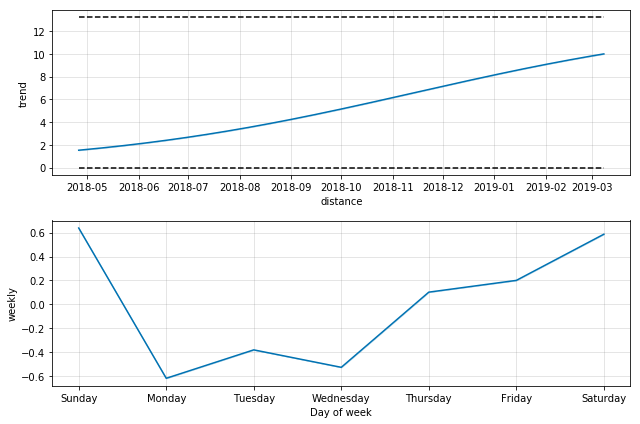

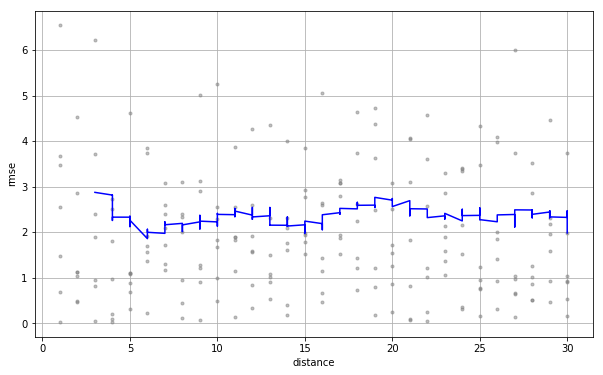

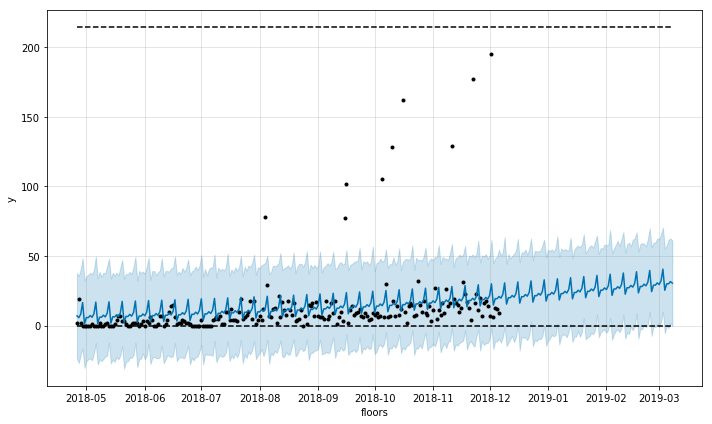

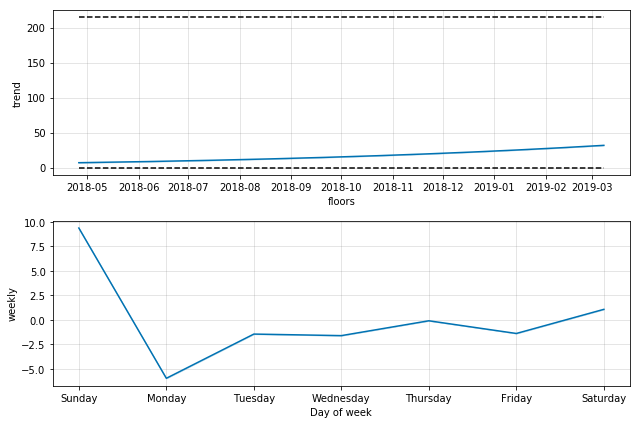

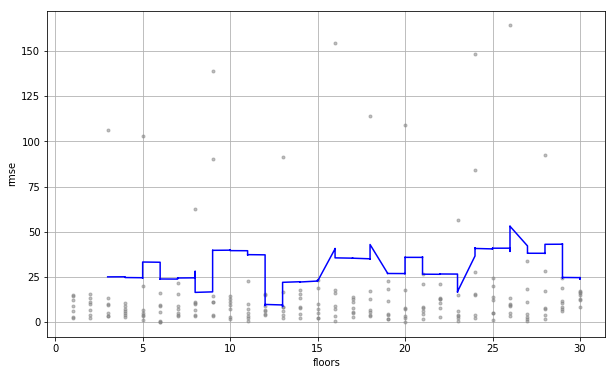

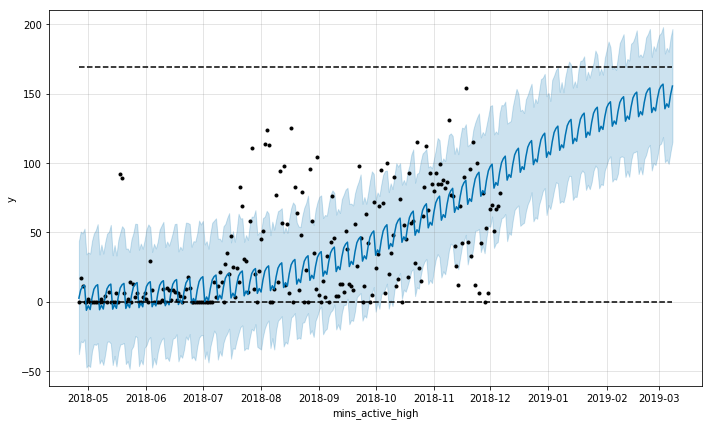

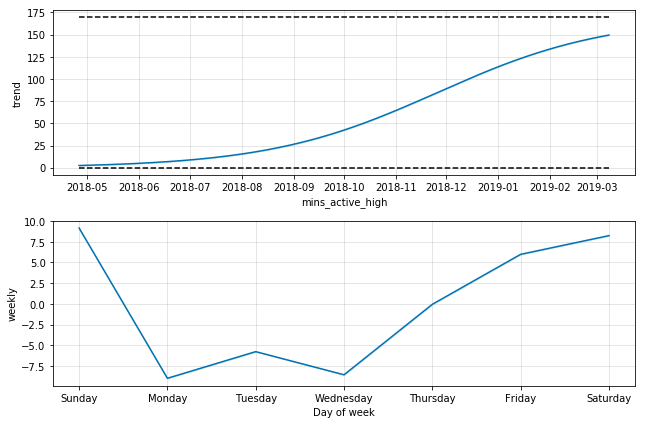

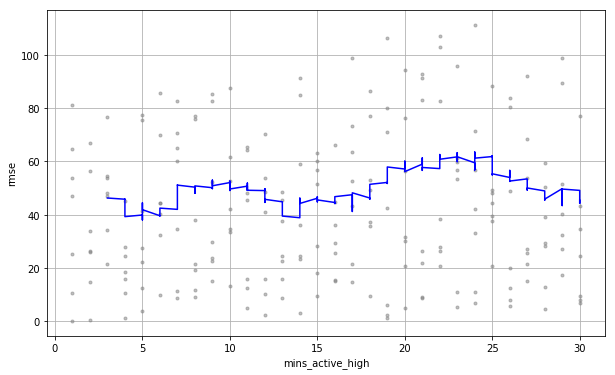

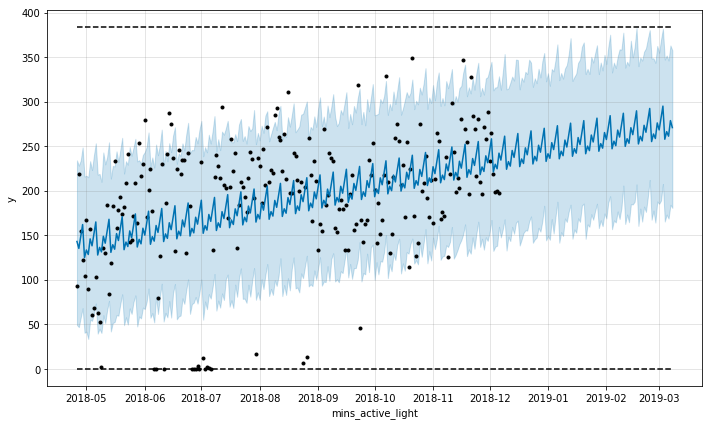

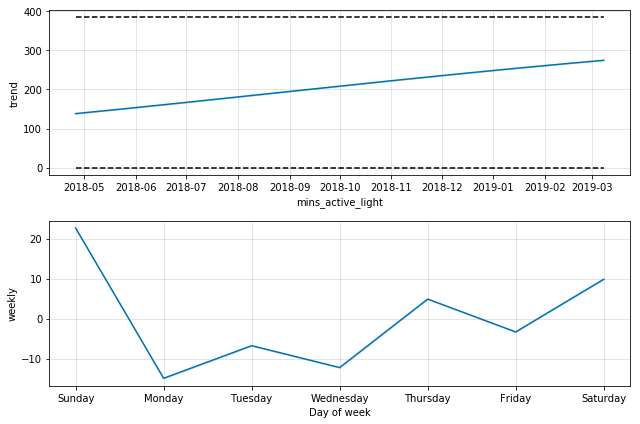

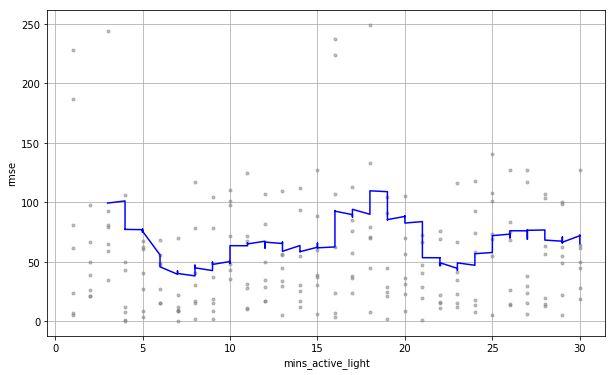

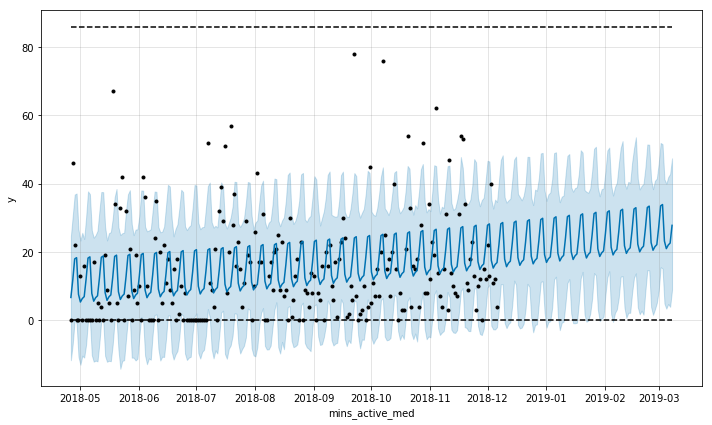

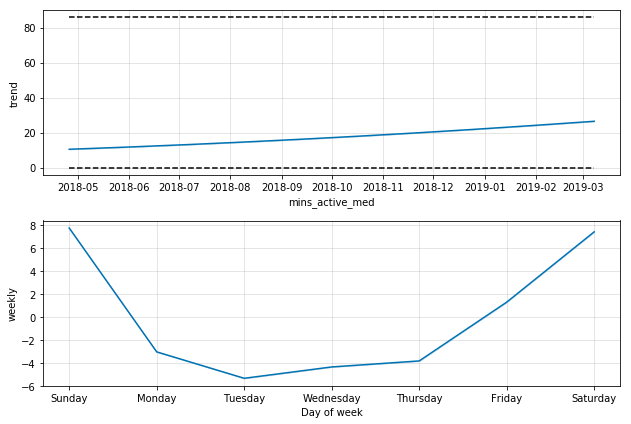

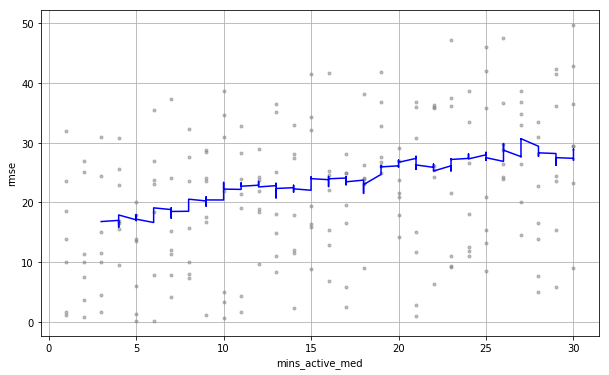

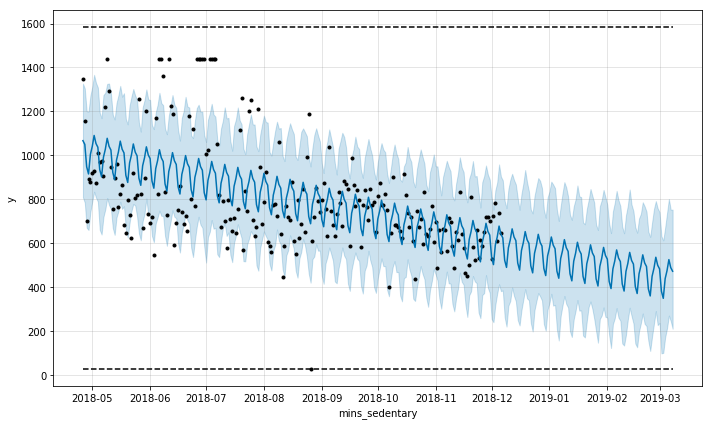

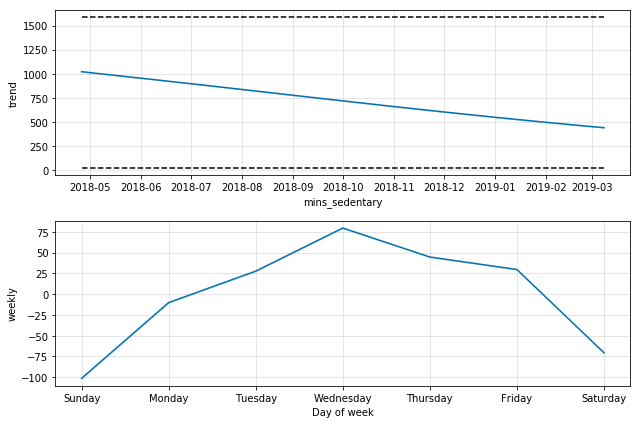

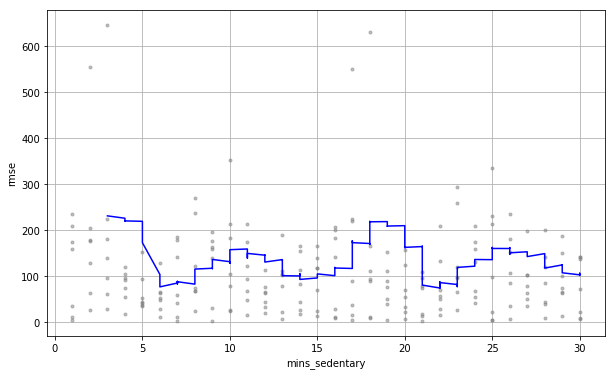

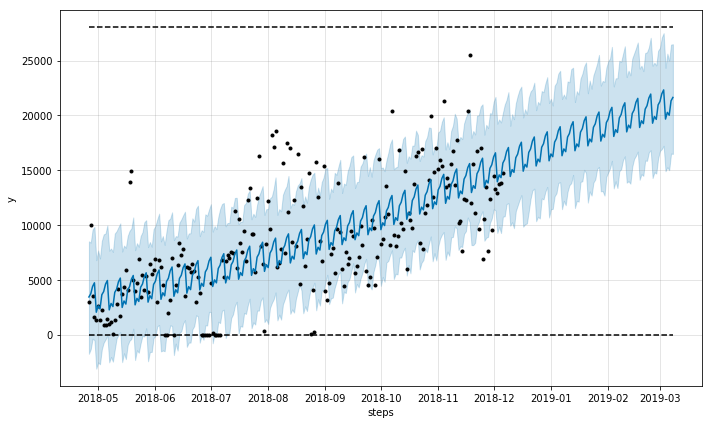

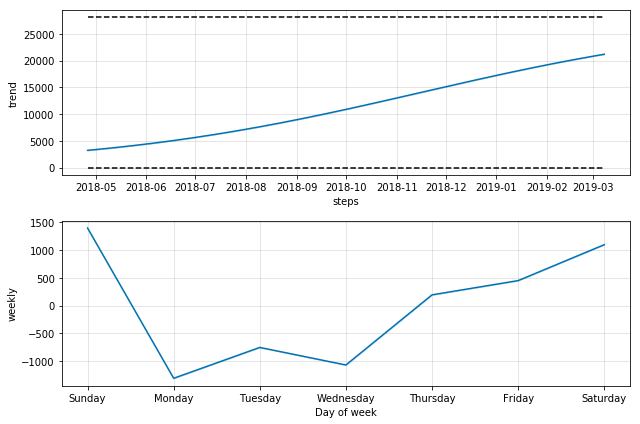

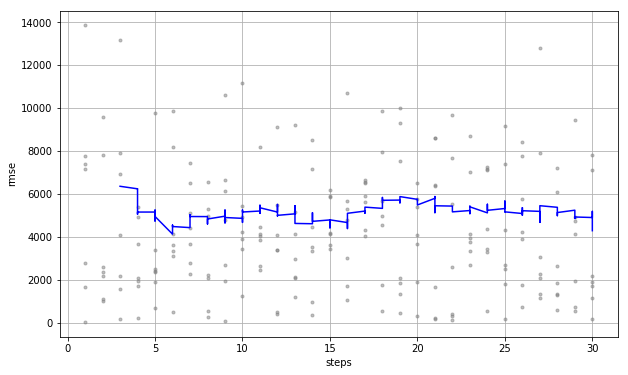

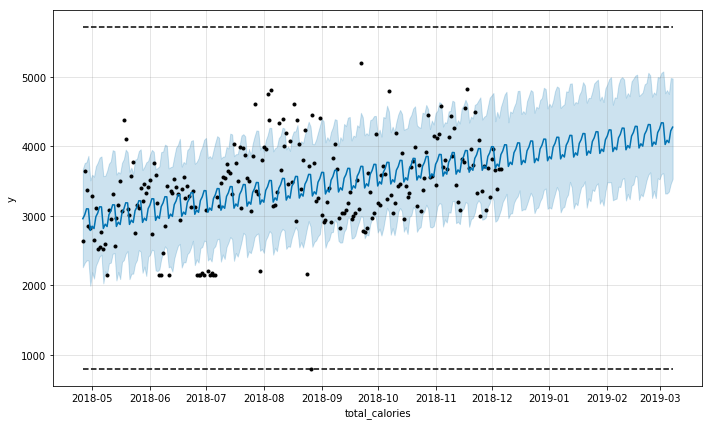

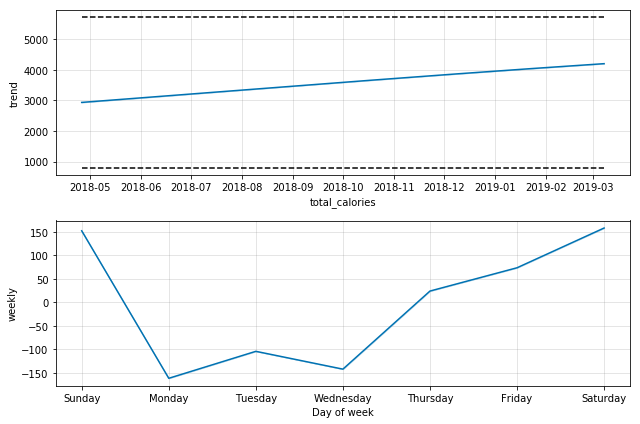

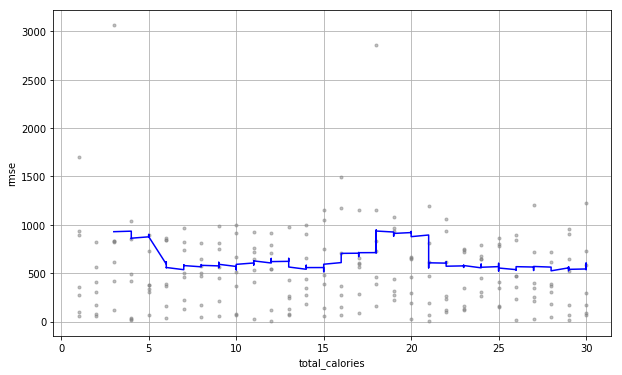

In [57]:
df_col = ['activity_calories', 'distance', 'floors', 'mins_active_high',
       'mins_active_light', 'mins_active_med', 'mins_sedentary', 'steps',
       'total_calories']
ranked_features = []

for col in df_col:
    print('Results for the ', col, ' feature:')
    d_df = pd.DataFrame()
    d_df['y'] = df[col]
    d_df['ds'] = pd.to_datetime(df['date'])

    d_df = d_df.groupby(['ds'])['y'].sum().reset_index()

    d_df['cap'] = d_df.y.max() * 1.1
    d_df['floor'] = d_df.y.min()

    m = Prophet(daily_seasonality=False, growth='logistic',changepoint_range=0.9)
    m.fit(d_df)

    future = m.make_future_dataframe(periods=92)
    future['cap'] = d_df.y.max() * 1.1
    future['floor'] = d_df.y.min()

    forecast = m.predict(future)

#     fig1 = m.plot(forecast)
    components_fig = m.plot(forecast)
    axes = components_fig.get_axes()
    axes[0].set_xlabel(col)

#     fig2 = m.plot_components(forecast)
    components_fig = m.plot_components(forecast)
    axes = components_fig.get_axes()
    axes[0].set_xlabel(col)

    
    df_cv = cross_validation(m, horizon='30 days')
    df_p = performance_metrics(df_cv)

#     fig3 = plot_cross_validation_metric(df_cv, metric='rmse')
    components_fig = plot_cross_validation_metric(df_cv, metric='rmse')
    axes = components_fig.get_axes()
    axes[0].set_xlabel(col)

    
    print('Top of performance metrics for ', col, 'sorted by rmse:')
    df_p['median'] = df[col].median()
    df_p['diff_of_rmse_&_median'] = abs(df_p['rmse'] - df[col].median())
    df_p['percent_diff'] = df_p['diff_of_rmse_&_median'] / df_p['median']
    print(df_p.sort_values(by='diff_of_rmse_&_median', ascending=True).head(3))
    print('median of percent diff for ', col, ': ', df_p['percent_diff'].median())
    ranked_features.append(df_p['percent_diff'].median())
 
#     df_p['horizon_num'] = df_p['horizon'].astype('str').str[:2].astype('int')
#     print('for feature: ', col)
#     sns.lineplot('horizon_num', 'rmse', data=df_p)
    
#     components_fig = sns.lineplot('horizon_num', 'rmse', data=df_p)
#     axes = components_fig.get_axes()
#     axes[0].set_xlabel(col)

#     df_p.drop(columns=['horizon_num'], inplace=True)

    
    print('@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@')
    print()

print(df_col)
print(ranked_features)

Run #1:

['activity_calories', 'distance', 'floors', 'mins_active_high', 'mins_active_light', 'mins_active_med', 'mins_sedentary', 'steps', 'total_calories']

[0.47146093275004286, 0.3589062085624734, 2.5717875991972394, 2.0565013066535665, 0.6757664804073794, 0.5365177395119702, 0.8238231870151846, 0.33848712409567727, 0.8271041477414698]

Run #2:

['activity_calories', 'distance', 'floors', 'mins_active_high', 'mins_active_light', 'mins_active_med', 'mins_sedentary', 'steps', 'total_calories']

[0.47146093275004286, 0.3589062085624734, 2.5717875991972394, 2.0565013066535665, 0.6757664804073794, 0.5365177395119702, 0.8238231870151846, 0.33848712409567727, 0.8271041477414698]

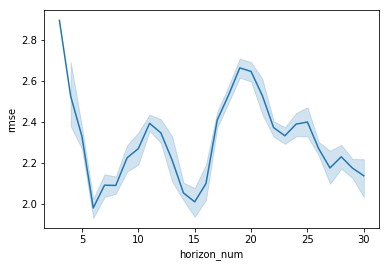

In [7]:
sns.lineplot('horizon_num', 'rmse', data=df_p)